In [1]:
%matplotlib notebook

import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import ipywidgets as widgets
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import torch
from skimage.color import lab2rgb, rgb2lab

from dataset.user_guided_dataset import UserGuidedVideoDataset
from dataset.util import unnormalize_lab
from model.user_guided_unet import UserGuidedUNet
from model.zhang_model import SIGGRAPHGenerator
from test_utils import predict_user_guided

device = torch.device('cuda')

In [18]:
image_path = '../datasets/bw-frames/test/00078.png'
model_path = '../checkpoint/siggraph_caffemodel/latest_net_G.pth'

In [19]:
# Both 3D tensors
L_channel, ab_channels, _, _ = UserGuidedVideoDataset('', False, [image_path])[0]

### Create Zhang model

In [20]:
model = SIGGRAPHGenerator(4, 2)

### Create UserGuidedUNet model

In [10]:
model = UserGuidedUNet()

### Load weights

In [21]:
model = model.to(device)
state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)

<All keys matched successfully>

### Create default inputs for the model

In [22]:
# All 4D tensors, with first dim being batch size (1)
input_L = L_channel.unsqueeze(0)
input_ab = torch.zeros_like(ab_channels).unsqueeze(0)
input_mask = torch.zeros_like(input_L)

### Get output

In [23]:
rgb = predict_user_guided(model, device, input_L, input_ab, input_mask)

### Visualize predicted values

<IPython.core.display.Javascript object>


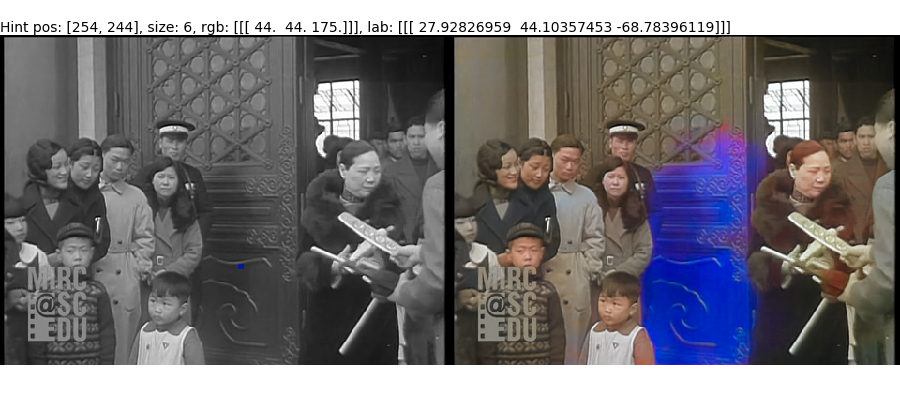

ColorPicker(value='blue', description='Pick a color')

IntSlider(value=3, continuous_update=False, description='Test:', max=20, min=1)

[[[ 27.92826959  44.10357453 -68.78396119]]]


In [24]:
grayscale_and_hints = unnormalize_lab(L_channel, torch.zeros((2, L_channel.shape[1], L_channel.shape[2])))
grayscale_and_hints = grayscale_and_hints.permute((1, 2, 0))
grayscale_and_hints = lab2rgb(grayscale_and_hints.detach().cpu().numpy())

plt.figure(figsize = (9, 4))
gs1 = gridspec.GridSpec(1, 2)
gs1.update(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)

ax1 = plt.subplot(gs1[0])
ax2 = plt.subplot(gs1[1])

ax1.imshow(grayscale_and_hints)
ax2.imshow(rgb)
ax1.set_axis_off()
ax2.set_axis_off()

hint_xy = None
hint_size = None
hint_rgb = None
hint_lab = None
hint_text = ax1.text(0, 0, "", va="bottom", ha="left")

candidate_ab_hint = None
candidate_ab_mask = None

def update_text_and_pred():
    global candidate_ab_hint
    global candidate_ab_mask
    hint_text.set_text(f'Hint pos: {hint_xy}, size: {hint_size}, rgb: {hint_rgb}, lab: {hint_lab}')
    
    if hint_xy is not None and hint_size is not None and hint_rgb is not None:
        candidate_ab_hint = input_ab.clone()
        candidate_ab_mask = input_mask.clone()

        x, y = hint_xy
        candidate_ab_mask[0, 0, y : y+hint_size, x : x+hint_size] = 1
        # Update hint and normalize it
        candidate_ab_hint[0, :, y : y+hint_size, x : x+hint_size] = \
            torch.tensor(hint_lab[0, 0, 1:]).unsqueeze(1).unsqueeze(1) / 110
        
        grayscale_and_hints = unnormalize_lab(L_channel, candidate_ab_hint.squeeze())
        grayscale_and_hints = grayscale_and_hints.permute((1, 2, 0))
        grayscale_and_hints = lab2rgb(grayscale_and_hints.detach().cpu().numpy())
        ax1.imshow(grayscale_and_hints)
        
        rgb = predict_user_guided(model, device, input_L, candidate_ab_hint, candidate_ab_mask)
        ax2.imshow(rgb)
        

def update_hint_pos(event):
    global hint_xy
    x = int(event.xdata)
    y = int(event.ydata)
    hint_xy = [x, y]
    update_text_and_pred()
    
def update_hint_size(change):
    global hint_size
    hint_size = int(change['new'])
    update_text_and_pred()
    
def update_hint_color(change):
    global hint_rgb
    global hint_lab
    hex_value = change['new'].lstrip('#')
    hint_rgb = np.array([[[int(hex_value[i : i+2], 16) for i in (0, 2, 4)]]]).astype('float')
    hint_lab = rgb2lab(hint_rgb / 255)
    print(hint_lab)
    update_text_and_pred()

ka = ax1.figure.canvas.mpl_connect('button_press_event', update_hint_pos)

color_picker = widgets.ColorPicker(
    concise=False,
    description='Pick a color',
    value='blue',
    disabled=False
)

slider = widgets.IntSlider(
    value=3,
    min=1,
    max=20,
    step=1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

slider.observe(update_hint_size, names='value')
color_picker.observe(update_hint_color, names='value')

display(color_picker)
display(slider)

### Commit selected value to hint and mask

In [12]:
input_ab = candidate_ab_hint.clone()
input_mask = candidate_ab_mask.clone()